<p style="font-family:newtimeroman; font-size:250%; text-align:center; border-radius: 10px 100px;">Solution to Facial Recognition System using a CNN Model</p>

# Importing Libraries

In [24]:
import numpy as np
import pandas as pd
import os
import shutil
import errno
import cv2
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt

# Copying Dataset

In [25]:
# This is a function for copying files or directories from 'src' to 'dest'.
def copy(src, dest):
    try:
        # shutil.copytree copies an entire directory tree, including all subdirectories.
        shutil.copytree(src, dest)
    except OSError as e:
        # errno.ENOTDIR means the source is a file and not a directory.
        if e.errno == errno.ENOTDIR:
            # shutil.copy copies a file from 'src' to 'dest'.
            shutil.copy(src, dest)
        else:
            print('Directory not copied. Error: %s' % e)

# Specify the source and destination paths for the dataset.            
src = '../input/lfwpeople'
dest = '../LFW/lfw4/lfw_home'
# Use the copy function to copy the files from source to destination.
copy(src,dest)
# Print the list of files in the source and destination directories.
print(os.listdir('../input/lfwpeople'))
print(os.listdir('../LFW/lfw4/lfw_home'))

Directory not copied. Error: [Errno 17] File exists: '../LFW/lfw4/lfw_home'
['pairsDevTrain.txt', 'lfw-funneled.tgz', 'pairsDevTest.txt', 'pairs.txt']
['joblib', 'lfw_funneled', 'pairs.txt', 'pairsDevTest.txt', 'pairsDevTrain.txt']


# Loading Dataset

In [26]:
# Specify the path to the dataset.
path = '../LFW/lfw4/'
print("Fetching LFW people dataset from:", path)

# Fetch the dataset from the specified path and only download the images of people with 80 or more faces.
lfw_dataset = sklearn.datasets.fetch_lfw_people(data_home = path, min_faces_per_person=80,  download_if_missing = False)

# Get the shape of the fetched dataset.
n_samples, h, w = lfw_dataset.images.shape
print("Fetched dataset with", n_samples, "samples")
# Set the seed for the numpy random number generator, which is used for creating random splits of the data for training and testing.
np.random.seed(42)
# Assign the image data to 'X'.
X = lfw_dataset.images
# Get the number of features in the dataset, which in this case would be the height of the images.
n_features = X.shape[1]

# Assign the target values to 'y'.
y = lfw_dataset.target
target_names = lfw_dataset.target_names
# Get the number of classes in the dataset.
n_classes = target_names.shape[0]

Fetching LFW people dataset from: ../LFW/lfw4/
Fetched dataset with 1140 samples


# Data Exploration

In [14]:
# Print out details regarding the dataset.
print(f"Number of images: {n_samples}")
print(f"Number of classes: {n_classes}")
print(f"Image shape: {h} x {w}")

Number of images: 1140
Number of classes: 5
Image shape: 62 x 47


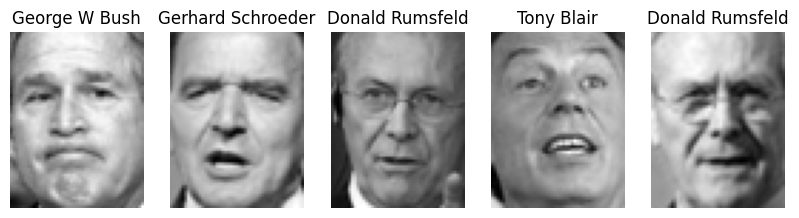

In [15]:
# Create a new figure to display images with a size of (10, 5).
plt.figure(figsize=(10, 5))
# Loop to display the first five images in the dataset.
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X[i], cmap='gray')
    plt.title(target_names[y[i]])
    plt.axis('off')
plt.show()

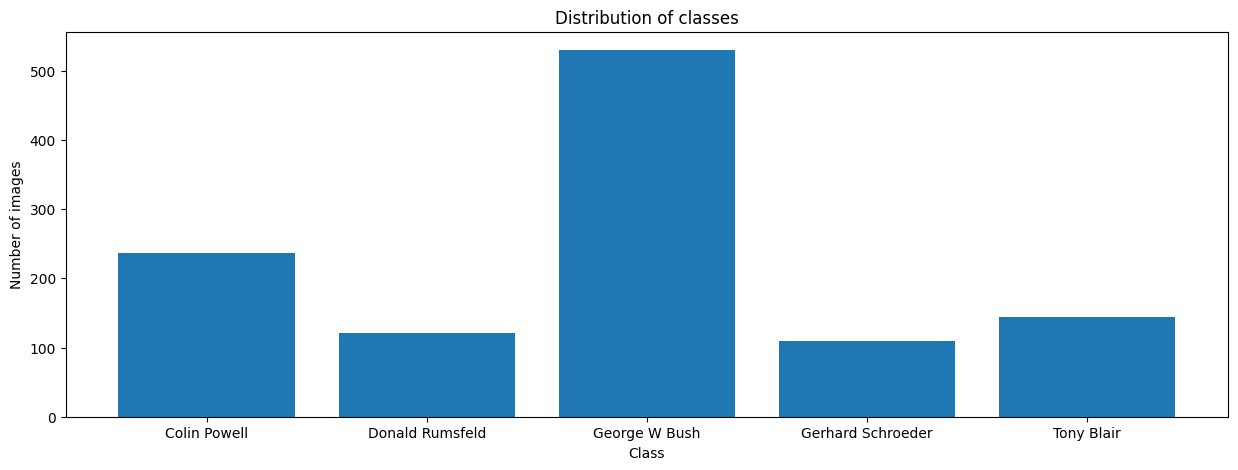

In [16]:
# Create a bar chart to visualise the amount of images for each class.
label, counts = np.unique(y, return_counts=True)
plt.figure(figsize=(15, 5))
plt.bar(target_names[label], counts)
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Distribution of classes')
plt.show()

# Data Preparation and Model Training

In [27]:
# Reshape the image data to a 4D array.
X = X.reshape(-1, h, w, 1)  

# Instantiate a LabelEncoder object. This will be used to transform class labels to integers.
label_encoder = LabelEncoder()
# Transform the class labels to integers.
y = label_encoder.fit_transform(y)
# One hot encode the integer class labels. This is necessary because the output of the model will be a softmax layer which provides a probability distribution over classes.
y = to_categorical(y)

# Split the data into a training set and a test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Initialize a Sequential model object which is a linear stack of layers.
model = Sequential()
# Add a convolutional layer where the input shape is set to the shape of the images.
model.add(Conv2D(32, (3, 3), input_shape=(h, w, 1), activation='relu'))
# Add a max pooling layer to reduce the spatial dimensions of the output from the previous layer.
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
# Flatten the tensor output from the previous layer. This is necessary because fully connected layers expect a 1D array as an input.
model.add(Flatten())
# Add a fully connected layer with 512 and 128 units.
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=128, activation='relu'))
# Add a softmax layer for multi-class classification.
model.add(Dense(units=n_classes, activation='softmax')) 

# Display a summary of the model architecture.
model.summary()

# Compile the model with the Adam optimiser, categorical crossentropy loss function, and accuracy as the metric to track.
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model to the training data for 20 epochs with a batch size of 32, and use the test set for validation.
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 60, 45, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 22, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 20, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 10, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 4480)              0         
                                                                 
 dense_9 (Dense)             (None, 512)              

# Evaluation

In [28]:
# Use the trained model to make predictions on the test set.
y_pred = model.predict(X_test)
# Get the class with the highest probability for each sample.
y_pred = np.argmax(y_pred, axis=1)
# Transform the predicted classes back to the original labels.
y_pred = label_encoder.inverse_transform(y_pred)

# Reverse the one-hot encoding of the test labels to compare with the predicted labels.
y_test_label_encoded = np.argmax(y_test, axis=1)

# Print the classification report for the predictions on the test set.
print("Predicting people's names on the test set")
print(classification_report(y_test_label_encoded, y_pred, target_names=target_names))

9/9 [==============================] - 0s 13ms/step
Predicting people's names on the test set
                   precision    recall  f1-score   support

     Colin Powell       0.98      0.94      0.96        64
  Donald Rumsfeld       0.90      0.81      0.85        32
    George W Bush       0.95      0.95      0.95       127
Gerhard Schroeder       0.84      0.90      0.87        29
       Tony Blair       0.86      0.94      0.90        33

         accuracy                           0.93       285
        macro avg       0.91      0.91      0.91       285
     weighted avg       0.93      0.93      0.93       285



In [29]:
# Print the confusion matrix for the predictions on the test set.
print(confusion_matrix(y_test_label_encoded, y_pred, labels=range(n_classes)))

[[ 60   1   3   0   0]
 [  0  26   2   3   1]
 [  1   2 121   1   2]
 [  0   0   1  26   2]
 [  0   0   1   1  31]]


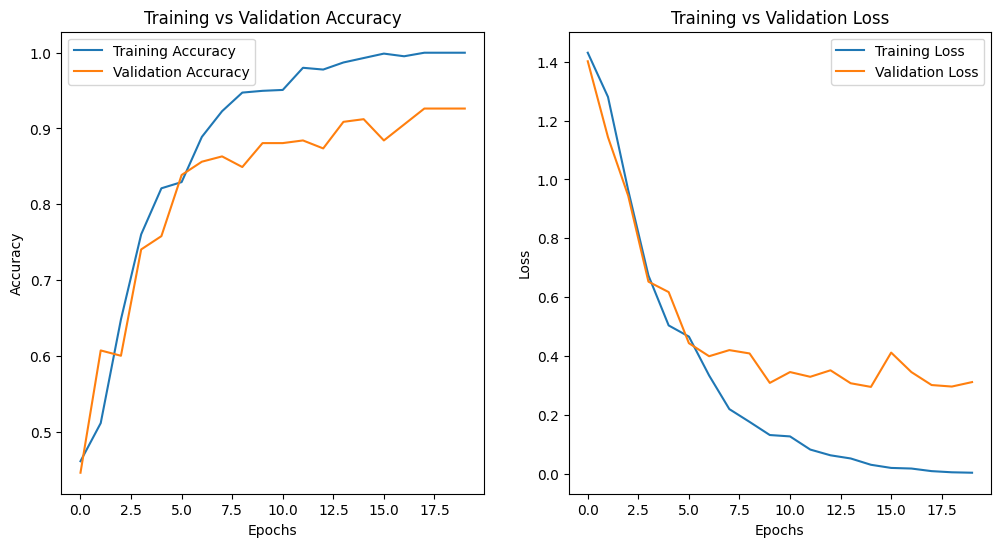

In [30]:
# Plotting the training and validation accuracy.
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

# Plotting the training and validation loss.
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

plt.show()